In [ ]:
import numpy as np
import pandas as pd
import pickle

df = pd.read_pickle("data/ger_preimp.p")

In [14]:
import pycaret
pycaret.__version__

'3.3.2'

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9007 entries, 0 to 10390
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       9007 non-null   Int64  
 1   recipient_status           9003 non-null   Int64  
 2   recipient_age              9007 non-null   Float64
 3   recipient_bmi              8996 non-null   Float64
 4   recipient_sex              9007 non-null   Int64  
 5   recipient_blood_type       9007 non-null   Int64  
 6   recipient_rhesus_factor    9007 non-null   Int64  
 7   MELD                       8810 non-null   Int64  
 8   recipient_followup_days    9002 non-null   Int64  
 9   recipient_followup_status  9002 non-null   Int64  
 10  graft_followup_days        9007 non-null   Int64  
 11  graft_followup_status      9002 non-null   Int64  
 12  cold_ischemia_time         3199 non-null   Int64  
 13  donor_age                  9007 non-null   Float64
 

In [16]:
df['1yr_graft'].mean()
#this means that roughly 30% of patients lost their liver graft 1 year after transplantation

0.297879427112246

In [17]:
sess_id = 123

target_value = '1yr_graft'

In [ ]:
args = {'data': df,
        'target': target_value,
        'session_id': sess_id,
        'train_size': 0.7,
        # 'test_data': df_usa,
        'preprocess': True,
        'imputation_type': 'iterative',
        'iterative_imputation_iters': 50,
        'numeric_iterative_imputer': 'br',
        'categorical_iterative_imputer': 'knn',
        # 'polynomial_features': True,
        # 'feature_selection': True,
        # 'n_features_to_select': 0.8,
        'ignore_features': ['recipient_followup_days', 'recipient_followup_status', 'graft_followup_days', 'graft_followup_status'],
        # 'keep_features': ['MELD', 'recipient_age', 'donor_age', 'recipient_bmi'],
        # 'remove_multicollinearity': True,
        # 'multicollinearity_threshold': 0.3,
        # 'pca': True,
        # 'pca_components': 10,
        'fold_strategy': 'stratifiedkfold',
        'fold': 5,
        # 'use_gpu': True,
        # 'fix_imbalance': True,
        # 'fix_imbalance_method': 'SMOTETomek',
        }

In [19]:
# import ClassificationExperiment and init the class
from pycaret.classification import *
s = setup(**args)
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

,Description,Value
0,Session id,123
1,Target,1yr_graft
2,Target type,Binary
3,Original data shape,"(9007, 28)"
4,Transformed data shape,"(9007, 24)"
5,Transformed train set shape,"(6304, 24)"
6,Transformed test set shape,"(2703, 24)"
7,Ignore features,4
8,Numeric features,23
9,Rows with missing values,86.1%


In [20]:
# init setup on exp
exp.setup(**args)

,Description,Value
0,Session id,123
1,Target,1yr_graft
2,Target type,Binary
3,Original data shape,"(9007, 28)"
4,Transformed data shape,"(9007, 24)"
5,Transformed train set shape,"(6304, 24)"
6,Transformed test set shape,"(2703, 24)"
7,Ignore features,4
8,Numeric features,23
9,Rows with missing values,86.1%


In [21]:
from pycaret.classification import *
all_models = models()
all_models

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [22]:
include_models = ['lr', 'knn', 'dt', 'svm', 'rf', 'ada', 'gbc', 'et', 'mlp', 'lightgbm']

In [ ]:
raise Exception("Stop")

In [35]:
# compare baseline models
best = compare_models(
    errors = 'raise',
    include=include_models,
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7184,0.6929,0.2188,0.5754,0.3168,0.1818,0.2160,2.0340
ada,Ada Boost Classifier,0.7129,0.6810,0.2455,0.5426,0.3377,0.1861,0.2103,2.0500
rf,Random Forest Classifier,0.7116,0.6774,0.1539,0.5622,0.2411,0.1291,0.1712,1.8320
lightgbm,Light Gradient Boosting Machine,0.7111,0.6717,0.2657,0.5304,0.3539,0.1936,0.2128,1.8760
et,Extra Trees Classifier,0.7081,0.6668,0.1337,0.5422,0.2143,0.1092,0.1501,1.8120
lr,Logistic Regression,0.7072,0.6579,0.1379,0.5324,0.2189,0.1101,0.1483,2.2820
knn,K Neighbors Classifier,0.6677,0.5674,0.2269,0.4002,0.2890,0.0933,0.1000,2.0380
mlp,MLP Classifier,0.6586,0.6360,0.3039,0.4521,0.2848,0.1147,0.1385,1.9000
svm,SVM - Linear Kernel,0.6282,0.6548,0.3873,0.2426,0.2870,0.1067,0.1175,2.0100
dt,Decision Tree Classifier,0.6255,0.5595,0.3962,0.3770,0.3861,0.1170,0.1172,2.0660


In [57]:
# Results will be saved in this list
results = []

# Loop over estimators
for model_name in include_models:
    print(f"Running model: {model_name}")
    
    base_model = create_model(estimator=model_name)
    
    print()
    
    tuned_model = tune_model(
        base_model,
        optimize='recall',
        n_iter=10,
        # return_train_score=True,
        # choose_better=True
    )
    
    cv_results = pull()  # Pulls results from the last `tune_model` call
        
    # Extract tuned hyperparameters
    tuned_params = tuned_model.get_params()
    
    # Combine results into one row
    results.append({
        'Model': model_name,

        'Accuracy_Fold_0': cv_results['Accuracy'][0],
        'Accuracy_Fold_1': cv_results['Accuracy'][1],
        'Accuracy_Fold_2': cv_results['Accuracy'][2],
        'Accuracy_Fold_3': cv_results['Accuracy'][3],
        'Accuracy_Fold_4': cv_results['Accuracy'][4],
        'Accuracy_Mean': cv_results['Accuracy']['Mean'],
        'Accuracy_Std': cv_results['Accuracy']['Std'],

        'AUC_Fold_0': cv_results['AUC'][0],
        'AUC_Fold_1': cv_results['AUC'][1],
        'AUC_Fold_2': cv_results['AUC'][2],
        'AUC_Fold_3': cv_results['AUC'][3],
        'AUC_Fold_4': cv_results['AUC'][4],
        'AUC_Mean': cv_results['AUC']['Mean'],
        'AUC_Std': cv_results['AUC']['Std'],

        'Recall_Fold_0': cv_results['Recall'][0],
        'Recall_Fold_1': cv_results['Recall'][1],
        'Recall_Fold_2': cv_results['Recall'][2],
        'Recall_Fold_3': cv_results['Recall'][3],
        'Recall_Fold_4': cv_results['Recall'][4],
        'Recall_Mean': cv_results['Recall']['Mean'],
        'Recall_Std': cv_results['Recall']['Std'],

        'Prec_Fold_0': cv_results['Prec.'][0],
        'Prec_Fold_1': cv_results['Prec.'][1],
        'Prec_Fold_2': cv_results['Prec.'][2],
        'Prec_Fold_3': cv_results['Prec.'][3],
        'Prec_Fold_4': cv_results['Prec.'][4],
        'Prec_Mean': cv_results['Prec.']['Mean'],
        'Prec_Std': cv_results['Prec.']['Std'],

        'F1_Fold_0': cv_results['F1'][0],
        'F1_Fold_1': cv_results['F1'][1],
        'F1_Fold_2': cv_results['F1'][2],
        'F1_Fold_3': cv_results['F1'][3],
        'F1_Fold_4': cv_results['F1'][4],
        'F1_Mean': cv_results['F1']['Mean'],
        'F1_Std': cv_results['F1']['Std'],

        'Hyperparameters': tuned_params
    })
    print()
    print()

results_df = pd.DataFrame(results)
print(results_df)

Running model: lr


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7153,0.6465,0.1573,0.5784,0.2474,0.1377,0.1824
1,0.7090,0.6598,0.1303,0.5506,0.2108,0.1091,0.1520
2,0.7010,0.6646,0.1250,0.4947,0.1996,0.0901,0.1226
3,0.7034,0.6510,0.1223,0.5111,0.1974,0.0930,0.1290
4,0.7071,0.6678,0.1547,0.5273,0.2392,0.1204,0.1553
Mean,0.7072,0.6579,0.1379,0.5324,0.2189,0.1101,0.1483
Std,0.0049,0.0080,0.0150,0.0295,0.0206,0.0177,0.0212


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6170,0.6469,0.6027,0.4036,0.4834,0.1976,0.2076
1,0.6328,0.6584,0.5931,0.4184,0.4906,0.2168,0.2248
2,0.6455,0.6631,0.6223,0.4341,0.5115,0.2469,0.2568
3,0.6281,0.6493,0.5718,0.4111,0.4783,0.2012,0.2078
4,0.6317,0.6677,0.6320,0.4210,0.5053,0.2304,0.2425
Mean,0.6310,0.6571,0.6044,0.4176,0.4938,0.2186,0.2279
Std,0.0092,0.0079,0.0213,0.0102,0.0127,0.0184,0.0193


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: knn


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6479,0.5287,0.2053,0.3453,0.2575,0.0459,0.0486
1,0.6638,0.5770,0.2128,0.3846,0.2740,0.0782,0.0840
2,0.6891,0.5916,0.2207,0.4560,0.2975,0.1278,0.1417
3,0.6495,0.5405,0.2128,0.3540,0.2658,0.0540,0.0570
4,0.6881,0.5992,0.2827,0.4609,0.3504,0.1604,0.1687
Mean,0.6677,0.5674,0.2269,0.4002,0.2890,0.0933,0.1000
Std,0.0180,0.0279,0.0283,0.0494,0.0335,0.0441,0.0474


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6630,0.5419,0.1600,0.3529,0.2202,0.0426,0.0480
1,0.6860,0.5822,0.1809,0.4359,0.2556,0.0979,0.1131
2,0.6955,0.6047,0.1729,0.4710,0.2529,0.1105,0.1324
3,0.6725,0.5563,0.1755,0.3905,0.2422,0.0703,0.0794
4,0.6905,0.6051,0.1920,0.4528,0.2697,0.1123,0.1290
Mean,0.6815,0.5780,0.1763,0.4206,0.2481,0.0867,0.1004
Std,0.0120,0.0255,0.0104,0.0431,0.0165,0.0267,0.0322


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: dt


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6352,0.5628,0.3840,0.3861,0.3850,0.1257,0.1257
1,0.6193,0.5453,0.3617,0.3617,0.3617,0.0905,0.0905
2,0.6154,0.5486,0.3830,0.3627,0.3726,0.0956,0.0956
3,0.6154,0.5501,0.3883,0.3641,0.3758,0.0983,0.0984
4,0.6421,0.5908,0.4640,0.4104,0.4355,0.1749,0.1756
Mean,0.6255,0.5595,0.3962,0.3770,0.3861,0.1170,0.1172
Std,0.0111,0.0167,0.0351,0.0190,0.0258,0.0314,0.0317


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6408,0.5579,0.3067,0.3734,0.3367,0.0937,0.0945
1,0.6622,0.5599,0.2606,0.3984,0.3151,0.1037,0.1078
2,0.6542,0.5648,0.3191,0.4000,0.3550,0.1229,0.1244
3,0.6685,0.5711,0.3138,0.4245,0.3609,0.1438,0.1468
4,0.6754,0.5877,0.2053,0.4096,0.2735,0.0933,0.1025
Mean,0.6602,0.5683,0.2811,0.4012,0.3283,0.1115,0.1152
Std,0.0120,0.0107,0.0432,0.0167,0.0317,0.0194,0.0186


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: svm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6630,0.6436,0.5253,0.4437,0.4811,0.2341,0.2360
1,0.7018,0.6619,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.7018,0.6708,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.4084,0.6358,0.8910,0.3221,0.4732,0.0626,0.1135
4,0.6659,0.6619,0.5200,0.4472,0.4809,0.2366,0.2381
Mean,0.6282,0.6548,0.3873,0.2426,0.2870,0.1067,0.1175
Std,0.1112,0.0130,0.3436,0.2032,0.2344,0.1075,0.1060


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7026,0.6300,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3569,0.6610,0.9521,0.3110,0.4689,0.0352,0.0909
2,0.4148,0.6605,0.8989,0.3256,0.4781,0.0717,0.1295
3,0.7018,0.6478,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.2976,0.6545,1.0000,0.2976,0.4587,0.0000,0.0000
Mean,0.4947,0.6508,0.5702,0.1869,0.2811,0.0214,0.0441
Std,0.1734,0.0114,0.4667,0.1528,0.2296,0.0286,0.0553


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: rf


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7026,0.6635,0.1600,0.5000,0.2424,0.1148,0.1437
1,0.7209,0.6813,0.1489,0.6364,0.2414,0.1446,0.2025
2,0.7098,0.6722,0.1649,0.5439,0.2531,0.1327,0.1693
3,0.7050,0.6770,0.1330,0.5208,0.2119,0.1031,0.1397
4,0.7198,0.6931,0.1627,0.6100,0.2568,0.1504,0.2006
Mean,0.7116,0.6774,0.1539,0.5622,0.2411,0.1291,0.1712
Std,0.0075,0.0098,0.0118,0.0523,0.0158,0.0178,0.0268


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6106,0.6541,0.6107,0.3990,0.4826,0.1919,0.2031
1,0.6511,0.6849,0.6463,0.4418,0.5248,0.2642,0.2762
2,0.6336,0.6919,0.5984,0.4198,0.4934,0.2201,0.2286
3,0.6519,0.6852,0.6011,0.4388,0.5073,0.2481,0.2555
4,0.6413,0.6968,0.6613,0.4328,0.5232,0.2553,0.2700
Mean,0.6377,0.6826,0.6235,0.4264,0.5063,0.2359,0.2467
Std,0.0151,0.0149,0.0255,0.0157,0.0165,0.0265,0.0273


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: ada


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6852,0.6555,0.2240,0.4421,0.2973,0.1217,0.1334
1,0.7216,0.6718,0.2713,0.5698,0.3676,0.2170,0.2415
2,0.7216,0.6830,0.2420,0.5796,0.3415,0.2011,0.2320
3,0.7129,0.6910,0.2340,0.5432,0.3271,0.1799,0.2057
4,0.7230,0.7038,0.2560,0.5783,0.3549,0.2107,0.2391
Mean,0.7129,0.6810,0.2455,0.5426,0.3377,0.1861,0.2103
Std,0.0143,0.0165,0.0166,0.0519,0.0243,0.0346,0.0406


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6963,0.6602,0.1573,0.4683,0.2355,0.1011,0.1245
1,0.7335,0.6992,0.1941,0.6887,0.3029,0.1977,0.2586
2,0.7105,0.6936,0.1569,0.5514,0.2443,0.1293,0.1686
3,0.7090,0.7000,0.1463,0.5446,0.2306,0.1194,0.1589
4,0.7349,0.7122,0.1893,0.7030,0.2983,0.1969,0.2617
Mean,0.7168,0.6930,0.1688,0.5912,0.2623,0.1489,0.1945
Std,0.0150,0.0175,0.0192,0.0904,0.0316,0.0406,0.0556


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Running model: gbc


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6923,0.6749,0.2027,0.4606,0.2815,0.1219,0.1385
1,0.7320,0.6968,0.2394,0.6338,0.3475,0.2200,0.2614
2,0.7240,0.6842,0.2207,0.6014,0.3230,0.1939,0.2324
3,0.7169,0.6971,0.2021,0.5714,0.2986,0.1692,0.2051
4,0.7270,0.7116,0.2293,0.6099,0.3333,0.2038,0.2425
Mean,0.7184,0.6929,0.2188,0.5754,0.3168,0.1818,0.2160
Std,0.0139,0.0125,0.0147,0.0608,0.0238,0.0342,0.0428


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6233,0.5528,0.3547,0.3634,0.3590,0.0923,0.0923
1,0.6376,0.5873,0.3936,0.3926,0.3931,0.1348,0.1348
2,0.6106,0.5592,0.3590,0.3506,0.3548,0.0760,0.0760
3,0.6376,0.5819,0.3537,0.3833,0.3679,0.1145,0.1146
4,0.6286,0.5870,0.3573,0.3712,0.3641,0.1019,0.1020
Mean,0.6275,0.5736,0.3637,0.3722,0.3678,0.1039,0.1039
Std,0.0101,0.0147,0.0151,0.0147,0.0134,0.0199,0.0199


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: et


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7105,0.6611,0.1440,0.5510,0.2283,0.1199,0.1611
1,0.7121,0.6712,0.1250,0.5802,0.2057,0.1118,0.1616
2,0.7018,0.6646,0.1277,0.5000,0.2034,0.0934,0.1266
3,0.7026,0.6546,0.1277,0.5053,0.2038,0.0950,0.1292
4,0.7135,0.6824,0.1440,0.5745,0.2303,0.1260,0.1719
Mean,0.7081,0.6668,0.1337,0.5422,0.2143,0.1092,0.1501
Std,0.0049,0.0095,0.0085,0.0338,0.0123,0.0131,0.0185


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6130,0.6611,0.5867,0.3978,0.4741,0.1854,0.1942
1,0.6495,0.6908,0.6330,0.4391,0.5185,0.2569,0.2675
2,0.6455,0.6872,0.6090,0.4329,0.5061,0.2418,0.2503
3,0.6606,0.6717,0.5984,0.4482,0.5125,0.2603,0.2667
4,0.6429,0.6975,0.6267,0.4312,0.5109,0.2445,0.2551
Mean,0.6423,0.6816,0.6108,0.4298,0.5044,0.2378,0.2468
Std,0.0158,0.0133,0.0172,0.0171,0.0157,0.0271,0.0271


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: mlp


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6860,0.6144,0.2107,0.4413,0.2852,0.1152,0.1281
1,0.6994,0.6468,0.3989,0.4950,0.4418,0.2394,0.2420
2,0.5036,0.6321,0.7846,0.3512,0.4852,0.1246,0.1637
3,0.7010,0.6322,0.0186,0.4667,0.0358,0.0132,0.0404
4,0.7032,0.6545,0.1067,0.5063,0.1762,0.0810,0.1181
Mean,0.6586,0.6360,0.3039,0.4521,0.2848,0.1147,0.1385
Std,0.0778,0.0138,0.2717,0.0553,0.1665,0.0736,0.0656


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3624,0.6160,0.9307,0.3097,0.4647,0.0333,0.0780
1,0.7050,0.6636,0.3564,0.5076,0.4188,0.2291,0.2355
2,0.5504,0.6520,0.7500,0.3735,0.4987,0.1671,0.2012
3,0.7002,0.6600,0.0000,0.0000,0.0000,-0.0032,-0.0260
4,0.3270,0.6716,0.9760,0.3037,0.4633,0.0171,0.0626
Mean,0.5290,0.6526,0.6026,0.2989,0.3691,0.0887,0.1103
Std,0.1608,0.0194,0.3722,0.1665,0.1863,0.0922,0.0957


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Running model: lightgbm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7002,0.6662,0.2587,0.4924,0.3392,0.1689,0.1836
1,0.7098,0.6685,0.2447,0.5287,0.3345,0.1798,0.2016
2,0.7082,0.6623,0.2553,0.5217,0.3429,0.1827,0.2020
3,0.7193,0.6732,0.2819,0.5579,0.3746,0.2180,0.2391
4,0.7183,0.6883,0.2880,0.5510,0.3783,0.2186,0.2379
Mean,0.7111,0.6717,0.2657,0.5304,0.3539,0.1936,0.2128
Std,0.0070,0.0090,0.0165,0.0233,0.0186,0.0207,0.0220


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6923,0.6269,0.3013,0.4728,0.3681,0.1777,0.1856
1,0.6971,0.6364,0.3112,0.4875,0.3799,0.1922,0.2007
2,0.6780,0.6175,0.2739,0.4364,0.3366,0.1385,0.1450
3,0.6844,0.6416,0.2633,0.4500,0.3322,0.1437,0.1526
4,0.6857,0.6388,0.2933,0.4564,0.3571,0.1620,0.1689
Mean,0.6875,0.6322,0.2886,0.4606,0.3548,0.1628,0.1706
Std,0.0066,0.0089,0.0176,0.0178,0.0182,0.0202,0.0205


Fitting 5 folds for each of 10 candidates, totalling 50 fits


      Model  Accuracy_Fold_0  Accuracy_Fold_1  Accuracy_Fold_2  \
0        lr           0.6170           0.6328           0.6455   
1       knn           0.6630           0.6860           0.6955   
2        dt           0.6408           0.6622           0.6542   
3       svm           0.7026           0.3569           0.4148   
4        rf           0.6106           0.6511           0.6336   
5       ada           0.6963           0.7335           0.7105   
6       gbc           0.6233           0.6376           0.6106   
7        et           0.6130           0.6495           0.6455   
8       mlp           0.3624           0.7050           0.5504   
9  lightgbm           0.6923           0.6971           0.6780   

   Accuracy_Fold_3  Accuracy_Fold_4  Accuracy_Mean  Accuracy_Std  AUC_Fold_0  \
0           0.6281           0.6317         0.6310        0.0092      0.6469   
1           0.6725           0.6905         0.6815

In [ ]:
results_df.to_csv("results_ger/model_comparison_results.csv", index=False)
results_df.to_excel("results_ger/model_comparison_results.xlsx", index=False)

In [ ]:
results_df_transposed = results_df.T.reset_index()
results_df_transposed.to_csv("results_ger/model_comparison_results_transposed.csv", index=False)
results_df_transposed.to_excel("results_ger/model_comparison_results_transposed.xlsx", index=False)

In [ ]:
raise Exception("Stop")

# Best Model

In [23]:
best_model = create_model(estimator = 'rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7026,0.6635,0.1600,0.5000,0.2424,0.1148,0.1437
1,0.7209,0.6813,0.1489,0.6364,0.2414,0.1446,0.2025
2,0.7098,0.6722,0.1649,0.5439,0.2531,0.1327,0.1693
3,0.7050,0.6770,0.1330,0.5208,0.2119,0.1031,0.1397
4,0.7198,0.6931,0.1627,0.6100,0.2568,0.1504,0.2006
Mean,0.7116,0.6774,0.1539,0.5622,0.2411,0.1291,0.1712
Std,0.0075,0.0098,0.0118,0.0523,0.0158,0.0178,0.0268


In [24]:
tuned_model = tune_model(
    best_model,
    n_iter=10,
    optimize = 'recall',
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6106,0.6541,0.6107,0.3990,0.4826,0.1919,0.2031
1,0.6511,0.6849,0.6463,0.4418,0.5248,0.2642,0.2762
2,0.6336,0.6919,0.5984,0.4198,0.4934,0.2201,0.2286
3,0.6519,0.6852,0.6011,0.4388,0.5073,0.2481,0.2555
4,0.6413,0.6968,0.6613,0.4328,0.5232,0.2553,0.2700
Mean,0.6377,0.6826,0.6235,0.4264,0.5063,0.2359,0.2467
Std,0.0151,0.0149,0.0255,0.0157,0.0165,0.0265,0.0273


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [25]:
print(tuned_model)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, monotonic_cst=None,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


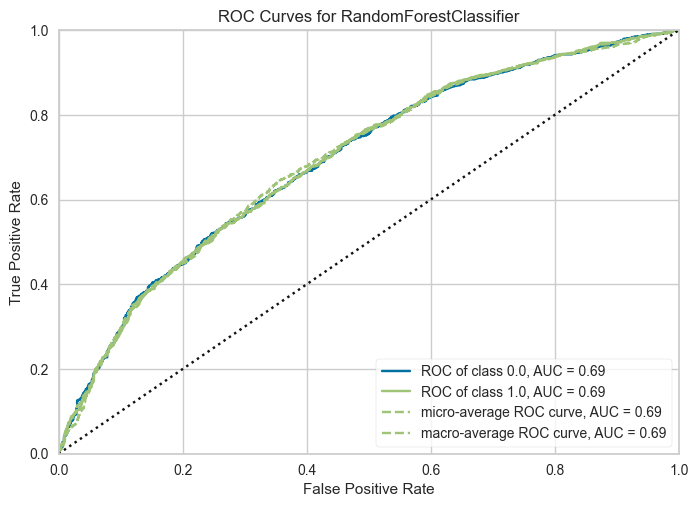

In [28]:
plot_model(tuned_model, plot = 'auc')

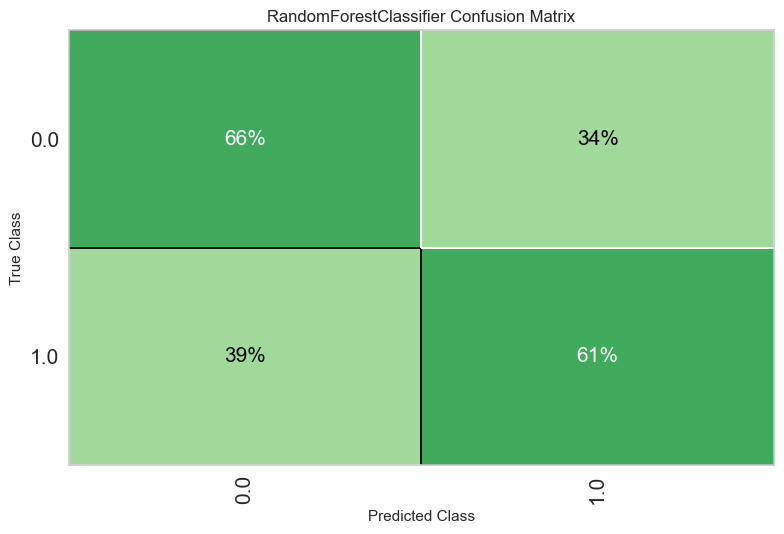

In [29]:
plot_model(tuned_model,
           plot = 'confusion_matrix',
           plot_kwargs = {'percent' : True}
           )

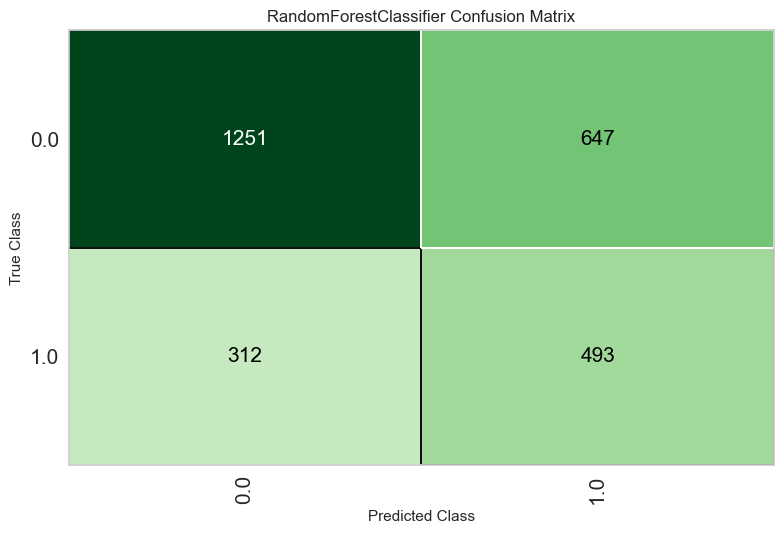

In [30]:
plot_model(tuned_model,
           plot = 'confusion_matrix',
           # plot_kwargs = {'percent' : True}
           )

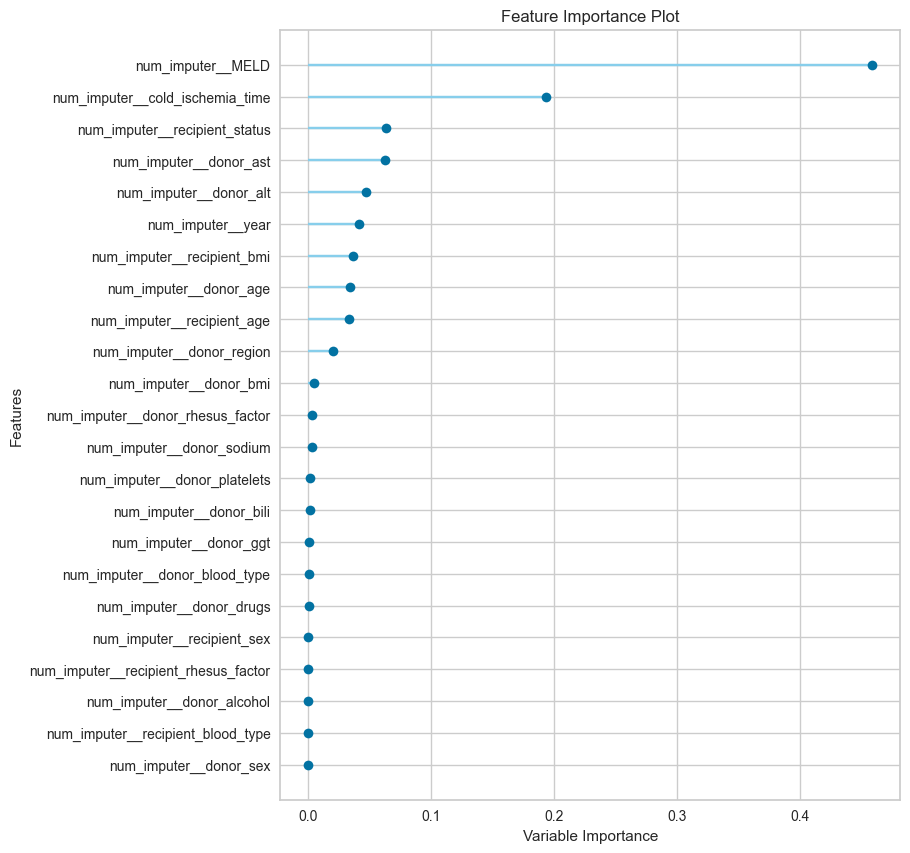

In [32]:
plot_model(tuned_model, plot = 'feature_all')

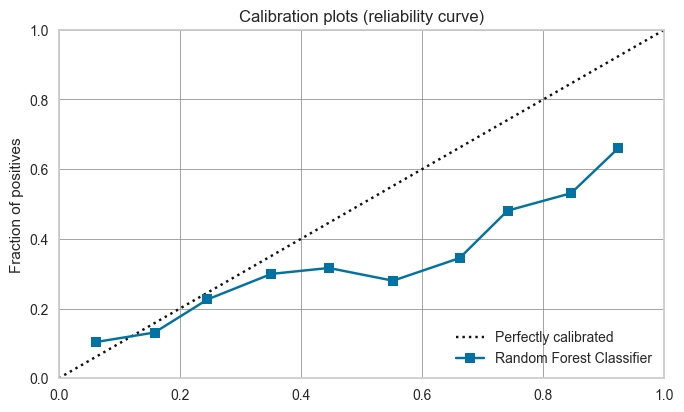

In [33]:
plot_model(tuned_model, plot = 'calibration')

In [36]:
import matplotlib.pyplot as plt
plt.figure().canvas.get_supported_filetypes()

{'eps': 'Encapsulated Postscript',
 'jpg': 'Joint Photographic Experts Group',
 'jpeg': 'Joint Photographic Experts Group',
 'pdf': 'Portable Document Format',
 'pgf': 'PGF code for LaTeX',
 'png': 'Portable Network Graphics',
 'ps': 'Postscript',
 'raw': 'Raw RGBA bitmap',
 'rgba': 'Raw RGBA bitmap',
 'svg': 'Scalable Vector Graphics',
 'svgz': 'Scalable Vector Graphics',
 'tif': 'Tagged Image File Format',
 'tiff': 'Tagged Image File Format',
 'webp': 'WebP Image Format'}

<Figure size 800x550 with 0 Axes>

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

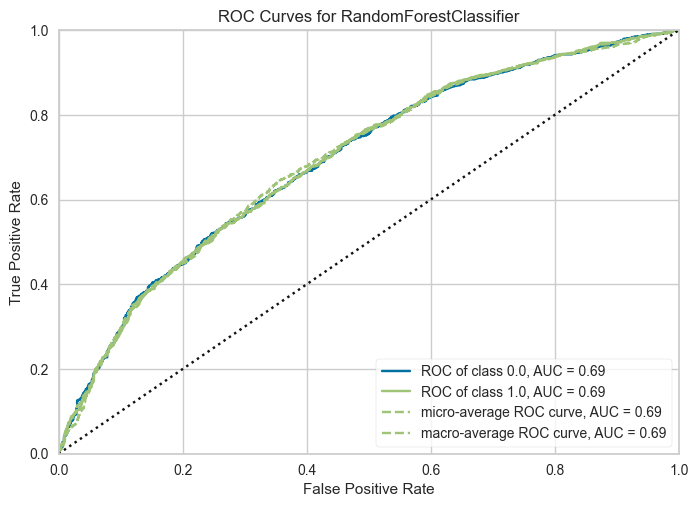

In [40]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.classifier import ROCAUC

X_train, X_test, y_train, y_test = get_config('X_train'), get_config('X_test_transformed'), get_config('y_train'), get_config('y_test_transformed')

visualizer = ROCAUC(tuned_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof(outpath="results/auc.svg")

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

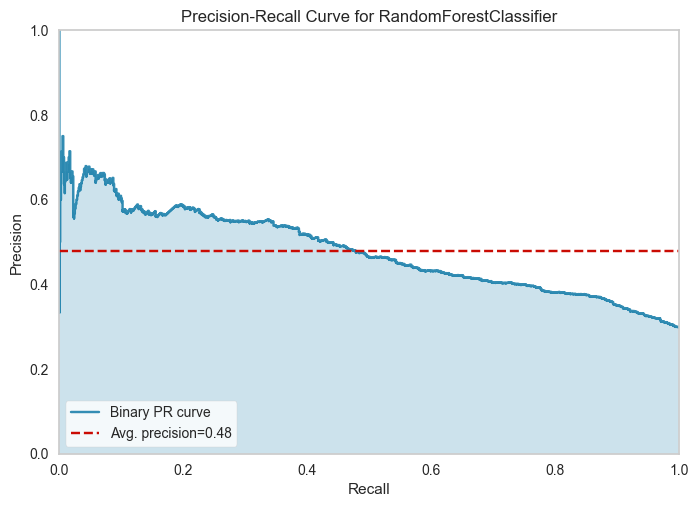

In [41]:
from yellowbrick.classifier import PrecisionRecallCurve
visualizer = PrecisionRecallCurve(tuned_model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof(outpath="results/prc.svg")

In [ ]:
raise Exception("Stop")